In [ ]:
# !pip install selenium pandas webdriver-manager


In [ ]:
import time
import random
import re
import pandas as pd
import sys
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException
from webdriver_manager.chrome import ChromeDriverManager
from urllib.parse import urlparse, urlunparse
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
def clean_url(url):
    parsed = urlparse(url)
    return urlunparse((parsed.scheme, parsed.netloc, parsed.path, '', '', ''))

def extract_experience(text):
    match = re.search(r'(\d+)[\+ ]*(?:\s*to\s*(\d+))?\s+years?', str(text), re.IGNORECASE)
    if match:
        if match.group(2):
            return f"{match.group(1)}-{match.group(2)}"
        else:
            return match.group(1)
    return None

def split_location(loc):
    parts = str(loc).split()
    if len(parts) >= 2:
        state = parts[-1]
        city = " ".join(parts[:-1])
    else:
        city, state = loc, ""
    return city, state


keyword_list = [
    # Languages
    "Python", "SQL", "Java", "JavaScript", "C++", "C#", "C Programming", "R Programming", "Scala", "Go", "Ruby", "PHP", "Shell", "PowerShell", "Bash", "TypeScript", "HTML", "CSS", "T-SQL", "VBA", "MATLAB",
    # Frameworks
    "Node.js", "React", "Angular", "Vue.js", "Express", "Next.js", "Flask", "Django", "ASP.NET", "Spring", "jQuery", "Laravel", "Symfony", "Ruby on Rails", "FastAPI", "Phoenix",
    # Cloud
    "AWS", "Azure", "GCP", "IBM Cloud", "Oracle", "Firebase", "Redshift", "Snowflake", "DataBricks", "BigQuery", "Digital Ocean", "OpenStack", "Colocation", "Watson", "VMware", "Heroku",
    # Databases
    "SQL Server", "MySQL", "PostgreSQL", "Cassandra", "MongoDB", "ElasticSearch", "DynamoDB", "Redis", "DB2", "Neo4j", "MariaDB", "CouchDB", "Couchbase", "SQLite", "Firestore",
    # Tools
    "Power BI", "Tableau", "Looker", "Excel", "Word", "SAP", "SAS", "SPSS", "Qlik", "SSIS", "SSRS", "Alteryx", "MicroStrategy", "Google Sheets", "Spreadsheets", "DAX", "Outlook", "Visio", "MS Access", "DataRobot", "Splunk", "Jira", "Confluence",
    # Systems and Services
    "Linux", "Linux Shell", "Zsh", "Windows Server", "Active Directory", "Group Policy", "Networking", "Switching", "Routing", "Firewalls", "VPN", "Remote Desktop",
    # Libraries
    "TensorFlow", "PyTorch", "NumPy", "Pandas", "Scikit-learn", "Keras", "Jupyter", "Matplotlib", "Seaborn", "NLTK", "OpenCV", "GraphQL",
    # Platforms and Concepts
    "Airflow", "Spark", "Kafka", "Hadoop", "Hive", "ETL", "DevOps", "CI/CD", "Git", "GitHub", "Bitbucket", "Terraform", "Ansible", "Jenkins", "Bamboo", "Nagios", "Prometheus", "Grafana", "New Relic", "Datadog", "Logstash", "Snort", "Wireshark",
    # Security & Integration
    "OAuth", "SSO", "SAML", "LDAP",
    # Roles & Concepts
    "IT Support", "Service Desk", "Help Desk", "Desktop Support", "Machine Learning", "Deep Learning", "NLP", "Microservices", "RESTful Services", "SOAP", "Rest API",
    # CRMs and CMS
    "Salesforce", "Zoho", "HubSpot", "Dynamics 365", "Shopify", "WordPress", "WooCommerce", "Magento", "Bootstrap", "Tailwind", "Webpack",
    # Agile Practices
    "Agile", "Scrum", "Kanban", "ITIL"
]

def extract_skills(text):
    return ", ".join(sorted(set([skill for skill in keyword_list if skill.lower() in str(text).lower()])))

In [17]:
options = Options()
options.add_argument("--headless")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")

service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
wait = WebDriverWait(driver, 3.6)

In [18]:
search_terms = [
    "Entry level IT", "Software Developer", "Software Engineer","Machine Learning Engineer", "IT Consultant" , "IT support", "Data Entry",
    "Computing", "ICT jobs", "IT internship", "Data Analyst", "Data Scientist", "Business Analyst",
    "Full Stack Developer", "AI Engineer", "Entry level tech", "Tech graduate program",
    "Front End Developer","IT", "Back End Developer","Cyber Security Analyst", "Cyber Security Architect",
    "Cloud Engineer", "Cloud Architect", "DevOps Engineer", "Machine Learning Engineer", "AI Engineer", 
    "IT Support Specialist", "Help Desk Technician", "Network Engineer", "Systems Administrator", "IT Project Manager",
    "Technical Project Manager", "Solutions Architect", "Enterprise Architect", "Database Administrator",  
]

job_data = []
visited_urls = set()
max_jobs = 9000


In [19]:
for term in search_terms:
    if len(job_data) >= max_jobs:
        break

    print(f"\n🔍 Query: {term}")
    driver.get(f"https://au.jora.com/j?sp=search&q={term}&psf=new")
    time.sleep(3)
    page_num = 1

    while len(job_data) < max_jobs:
        try:
            popup = driver.find_element(By.CSS_SELECTOR, 'div[data-automation="modal"]')
            close_btn = popup.find_element(By.CSS_SELECTOR, 'button')
            close_btn.click()
            time.sleep(1)
        except:
            pass

        try:
            wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, "div.job-card.result.organic-job")))
            job_cards = driver.find_elements(By.CSS_SELECTOR, "div.job-card.result.organic-job")
        except:
            break

        for card in job_cards:
            if len(job_data) >= max_jobs:
                break
            try:
                title_el = card.find_element(By.CSS_SELECTOR, "h2.job-title a.job-link")
                company_el = card.find_element(By.CSS_SELECTOR, "div.job-info span.job-company")
                location_el = card.find_element(By.CSS_SELECTOR, "div.job-info a.job-location")
                summary_el = card.find_element(By.CSS_SELECTOR, "div.job-abstract")

                title = title_el.text.strip()
                company = company_el.text.strip()
                location = location_el.text.strip()
                summary = summary_el.text.strip()
                job_url = clean_url(title_el.get_attribute("href"))

                if job_url in visited_urls:
                    continue
                visited_urls.add(job_url)

                city, state = split_location(location)
                skills = extract_skills(summary)
                experience = extract_experience(summary)

                job_data.append({
                    "Title": title,
                    "Company": company,
                    "City": city,
                    "State": state,
                    "Description": summary,
                    "Skills": skills,
                    "Experience": experience,
                    "Job URL": job_url
                })

                percent = round(len(job_data) / max_jobs * 100, 2)
                sys.stdout.write(f"\r📊 Scraping progress: {percent}%")
                sys.stdout.flush()

            except:
                continue

        try:
            next_btn = driver.find_element(By.CSS_SELECTOR, "a.next-page-button")
            driver.execute_script("arguments[0].click();", next_btn)
            time.sleep(random.uniform(2.0, 3.5))
            page_num += 1
        except NoSuchElementException:
            break

driver.quit()
print("\n✅ Scraping completed.")



🔍 Query: Entry level IT
📊 Scraping progress: 5.79%
🔍 Query: Software Developer
📊 Scraping progress: 10.29%
🔍 Query: Software Engineer
📊 Scraping progress: 14.38%
🔍 Query: Machine Learning Engineer
📊 Scraping progress: 19.94%
🔍 Query: IT Consultant
📊 Scraping progress: 23.58%
🔍 Query: IT support
📊 Scraping progress: 25.99%
🔍 Query: Data Entry
📊 Scraping progress: 29.91%
🔍 Query: Computing
📊 Scraping progress: 34.63%
🔍 Query: ICT jobs
📊 Scraping progress: 37.68%
🔍 Query: IT internship
📊 Scraping progress: 43.02%
🔍 Query: Data Analyst
📊 Scraping progress: 46.93%
🔍 Query: Data Scientist
📊 Scraping progress: 49.2%%
🔍 Query: Business Analyst
📊 Scraping progress: 52.97%
🔍 Query: Full Stack Developer
📊 Scraping progress: 57.23%
🔍 Query: AI Engineer
📊 Scraping progress: 58.79%
🔍 Query: Entry level tech
📊 Scraping progress: 60.23%
🔍 Query: Tech graduate program
📊 Scraping progress: 62.09%
🔍 Query: Front End Developer
📊 Scraping progress: 65.38%
🔍 Query: IT
📊 Scraping progress: 67.7%%
🔍 Query: B

In [35]:
df_final = pd.DataFrame(job_data)[[
    "Title",
    "Company",
    "City",
    "State",
    "Description",
    "Skills",
    "Experience",
    "Job URL"
]]

df_final.to_csv("enriched_jora_jobs_9000.csv", index=False, encoding="utf-8")

print(f"📁 Saved {len(df_final)} jobs to jora_jobs_9000.csv")
print(df_final.head())

📁 Saved 9000 jobs to jora_jobs_9000.csv
                                        Title                Company  \
0       Entry- Level IT Support / IT Graduate        Teekay Shipping   
1  IT Support & Website Content Administrator  Holidays of Australia   
2        IT Traineeship - Call Centre Support           WorkVentures   
3                       It Support Technician            Tropix Tech   
4          Entry Level/Support Desk Help/ CRM         Kirra Services   

              City State                                        Description  \
0       Sydney CBD   NSW  Provide first-line IT support for hardware, so...   
1         Adelaide    SA  Hybrid role combining IT support and website c...   
2       Alexandria   NSW  Entry-level IT helpdesk support role with on-t...   
3  Parramatta Park   QLD  Provide basic IT support for Windows, servers,...   
4        Australia                       Entry Level/Support Desk Help/ CRM   

                  Skills Experience  \
0       IT Su

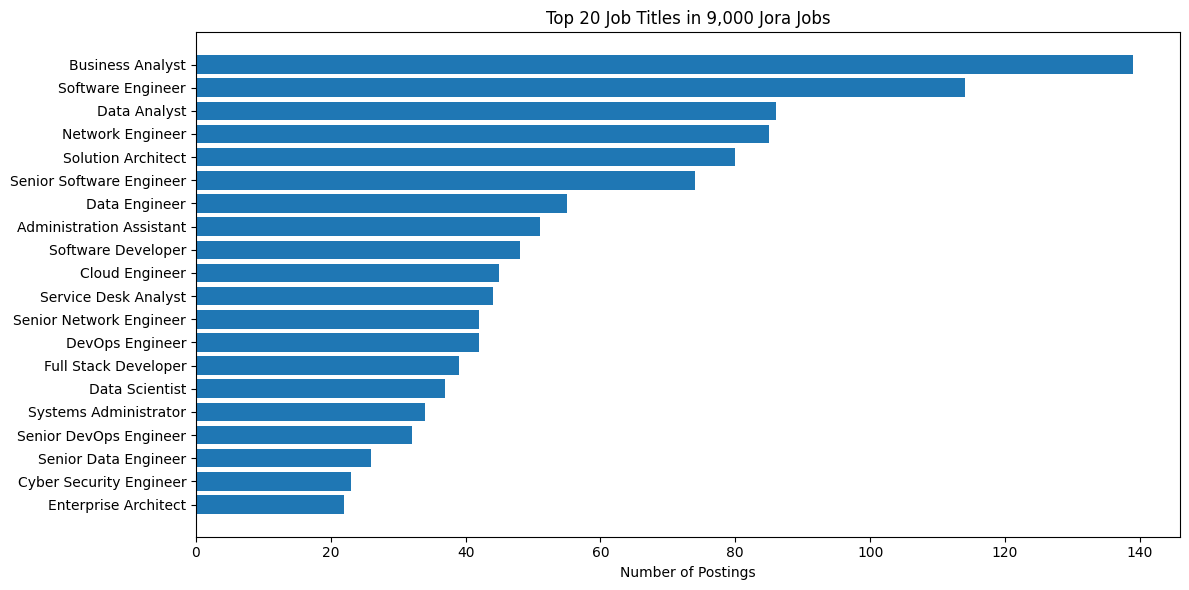

In [21]:
top_titles = df_final["Title"].dropna().value_counts().head(20)

plt.figure(figsize=(12, 6))
plt.barh(top_titles.index[::-1], top_titles.values[::-1])
plt.xlabel("Number of Postings")
plt.title("Top 20 Job Titles in 9,000 Jora Jobs")
plt.tight_layout()
plt.show()

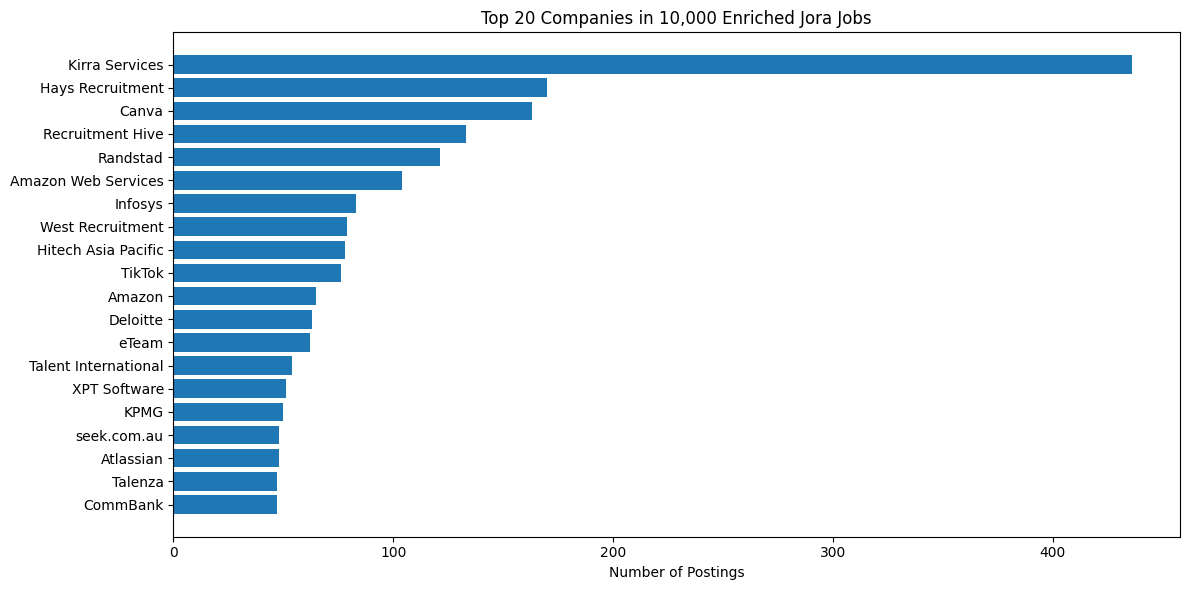

In [22]:
top_companies = df_final["Company"].dropna().value_counts().head(20)

plt.figure(figsize=(12, 6))
plt.barh(top_companies.index[::-1], top_companies.values[::-1])
plt.xlabel("Number of Postings")
plt.title("Top 20 Companies in 10,000 Enriched Jora Jobs")
plt.tight_layout()
plt.show()

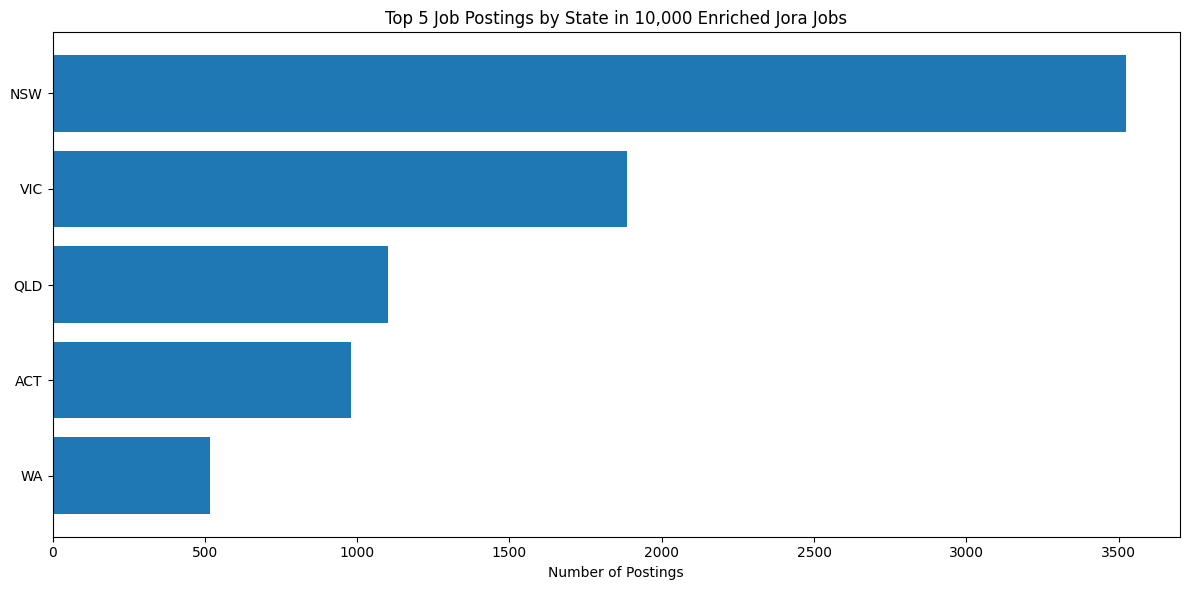

In [26]:
top_states = df_final["State"].dropna().value_counts().head(5)

plt.figure(figsize=(12, 6))
plt.barh(top_states.index[::-1], top_states.values[::-1])
plt.xlabel("Number of Postings")
plt.title("Top 5 Job Postings by State in 10,000 Enriched Jora Jobs")
plt.tight_layout()
plt.show()


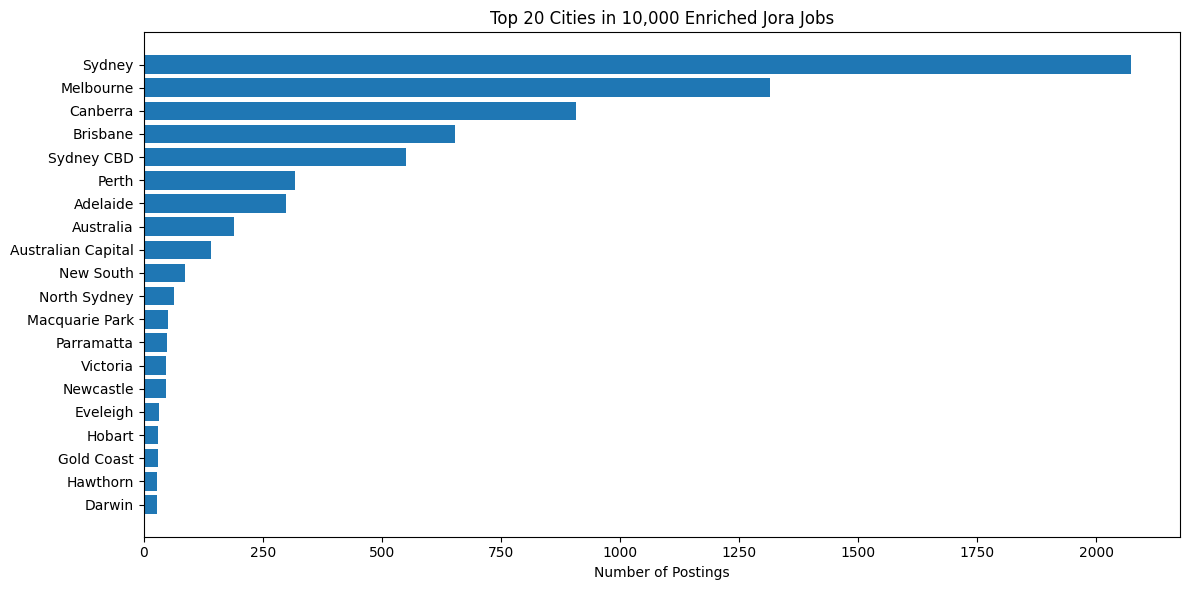

In [27]:
top_cities = df_final["City"].dropna().value_counts().head(20)

plt.figure(figsize=(12, 6))
plt.barh(top_cities.index[::-1], top_cities.values[::-1])
plt.xlabel("Number of Postings")
plt.title("Top 20 Cities in 10,000 Enriched Jora Jobs")
plt.tight_layout()
plt.show()


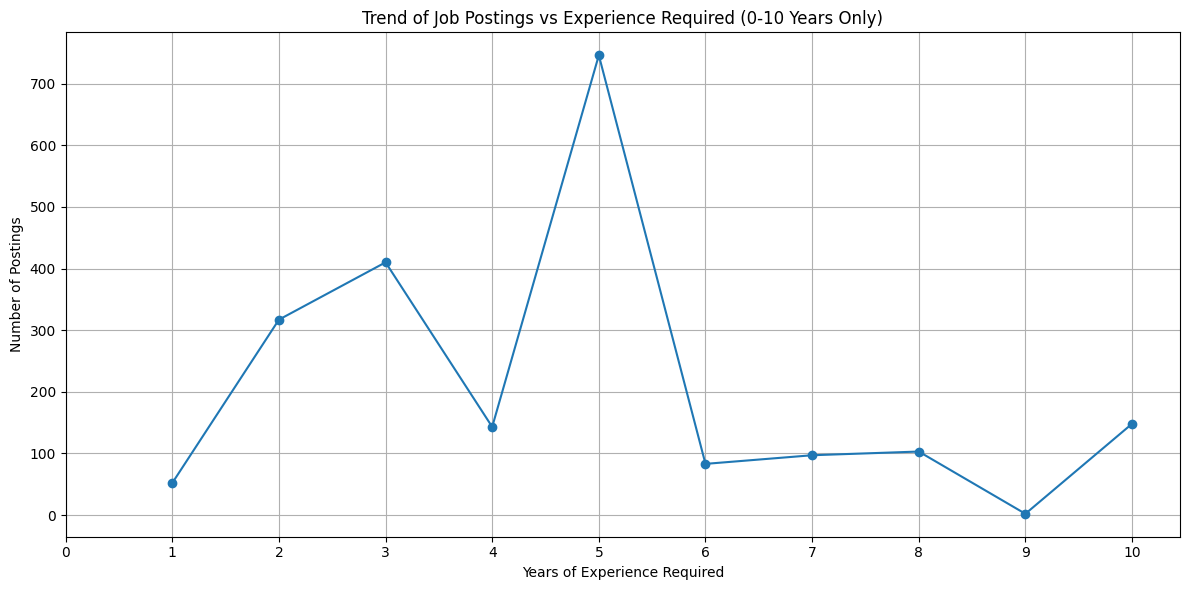

In [ ]:
experience_levels = pd.to_numeric(df_final["Experience"].dropna(), errors='coerce').dropna()
experience_counts = experience_levels.value_counts().sort_index()
experience_counts = experience_counts[(experience_counts.index >= 0) & (experience_counts.index <= 10)]

plt.figure(figsize=(12,6))
plt.plot(experience_counts.index, experience_counts.values, marker='o')
plt.xlabel("Years of Experience Required")
plt.ylabel("Number of Postings")
plt.title("Trend of Job Postings vs Experience Required (0-10 Years Only)")
plt.xticks(range(0, 11))
plt.grid(True)
plt.tight_layout()
plt.show()
